# Lineitem Thread Count Performance Comparison
Comparing baseline (without OVC) vs OVC-enabled sort performance

In [1]:
import re
import matplotlib.pyplot as plt
import numpy as np

# Configure matplotlib for better-looking plots
plt.style.use("custom_plt_sytle.mplstyle")

In [2]:
def parse_log_file(filename):
    """Parse the benchmark log file and extract performance metrics from summary table"""
    data = []
    
    with open(filename, 'r') as f:
        lines = f.readlines()
    
    # Find the summary table and parse it
    for line in lines:
        # Look for table rows with Thread_X pattern
        match = re.match(r'Thread_(\d+)\s+(\d+)\s+([\d.]+)\s+GB\s+([\d.]+)\s+(\d+)\s+(\d+)\s+(\d+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+(\d+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)', line)
        if match:
            threads = int(match.group(1))
            total_time = float(match.group(8))
            throughput = float(match.group(12))
            read_mb = float(match.group(13))
            write_mb = float(match.group(14))
            
            total_io_gb = (read_mb + write_mb) / 1024.0
            
            data.append({
                'threads': threads,
                'total_time': total_time,
                'throughput': throughput,
                'total_io_gb': total_io_gb,
                'per_thread_throughput': throughput / threads,
                'io_bandwidth_gbps': total_io_gb / total_time
            })
    
    return sorted(data, key=lambda x: x['threads'])

In [3]:
# Parse both log files
baseline_data = parse_log_file('lineitem_thread_count_2025-10-03_19-34-00_baseline.log')
ovc_data = parse_log_file('lineitem_thread_count_2025-10-03_19-34-00_ovc.log')

print(f"Baseline data points: {len(baseline_data)}")
print(f"OVC data points: {len(ovc_data)}")

Baseline data points: 6
OVC data points: 6


In [4]:
# Extract data for plotting
baseline_threads = [d['threads'] for d in baseline_data]
baseline_throughput = [d['throughput'] for d in baseline_data]
baseline_time = [d['total_time'] for d in baseline_data]
baseline_io = [d['total_io_gb'] for d in baseline_data]
baseline_per_thread = [d['per_thread_throughput'] for d in baseline_data]
baseline_bandwidth = [d['io_bandwidth_gbps'] for d in baseline_data]

ovc_threads = [d['threads'] for d in ovc_data]
ovc_throughput = [d['throughput'] for d in ovc_data]
ovc_time = [d['total_time'] for d in ovc_data]
ovc_io = [d['total_io_gb'] for d in ovc_data]
ovc_per_thread = [d['per_thread_throughput'] for d in ovc_data]
ovc_bandwidth = [d['io_bandwidth_gbps'] for d in ovc_data]

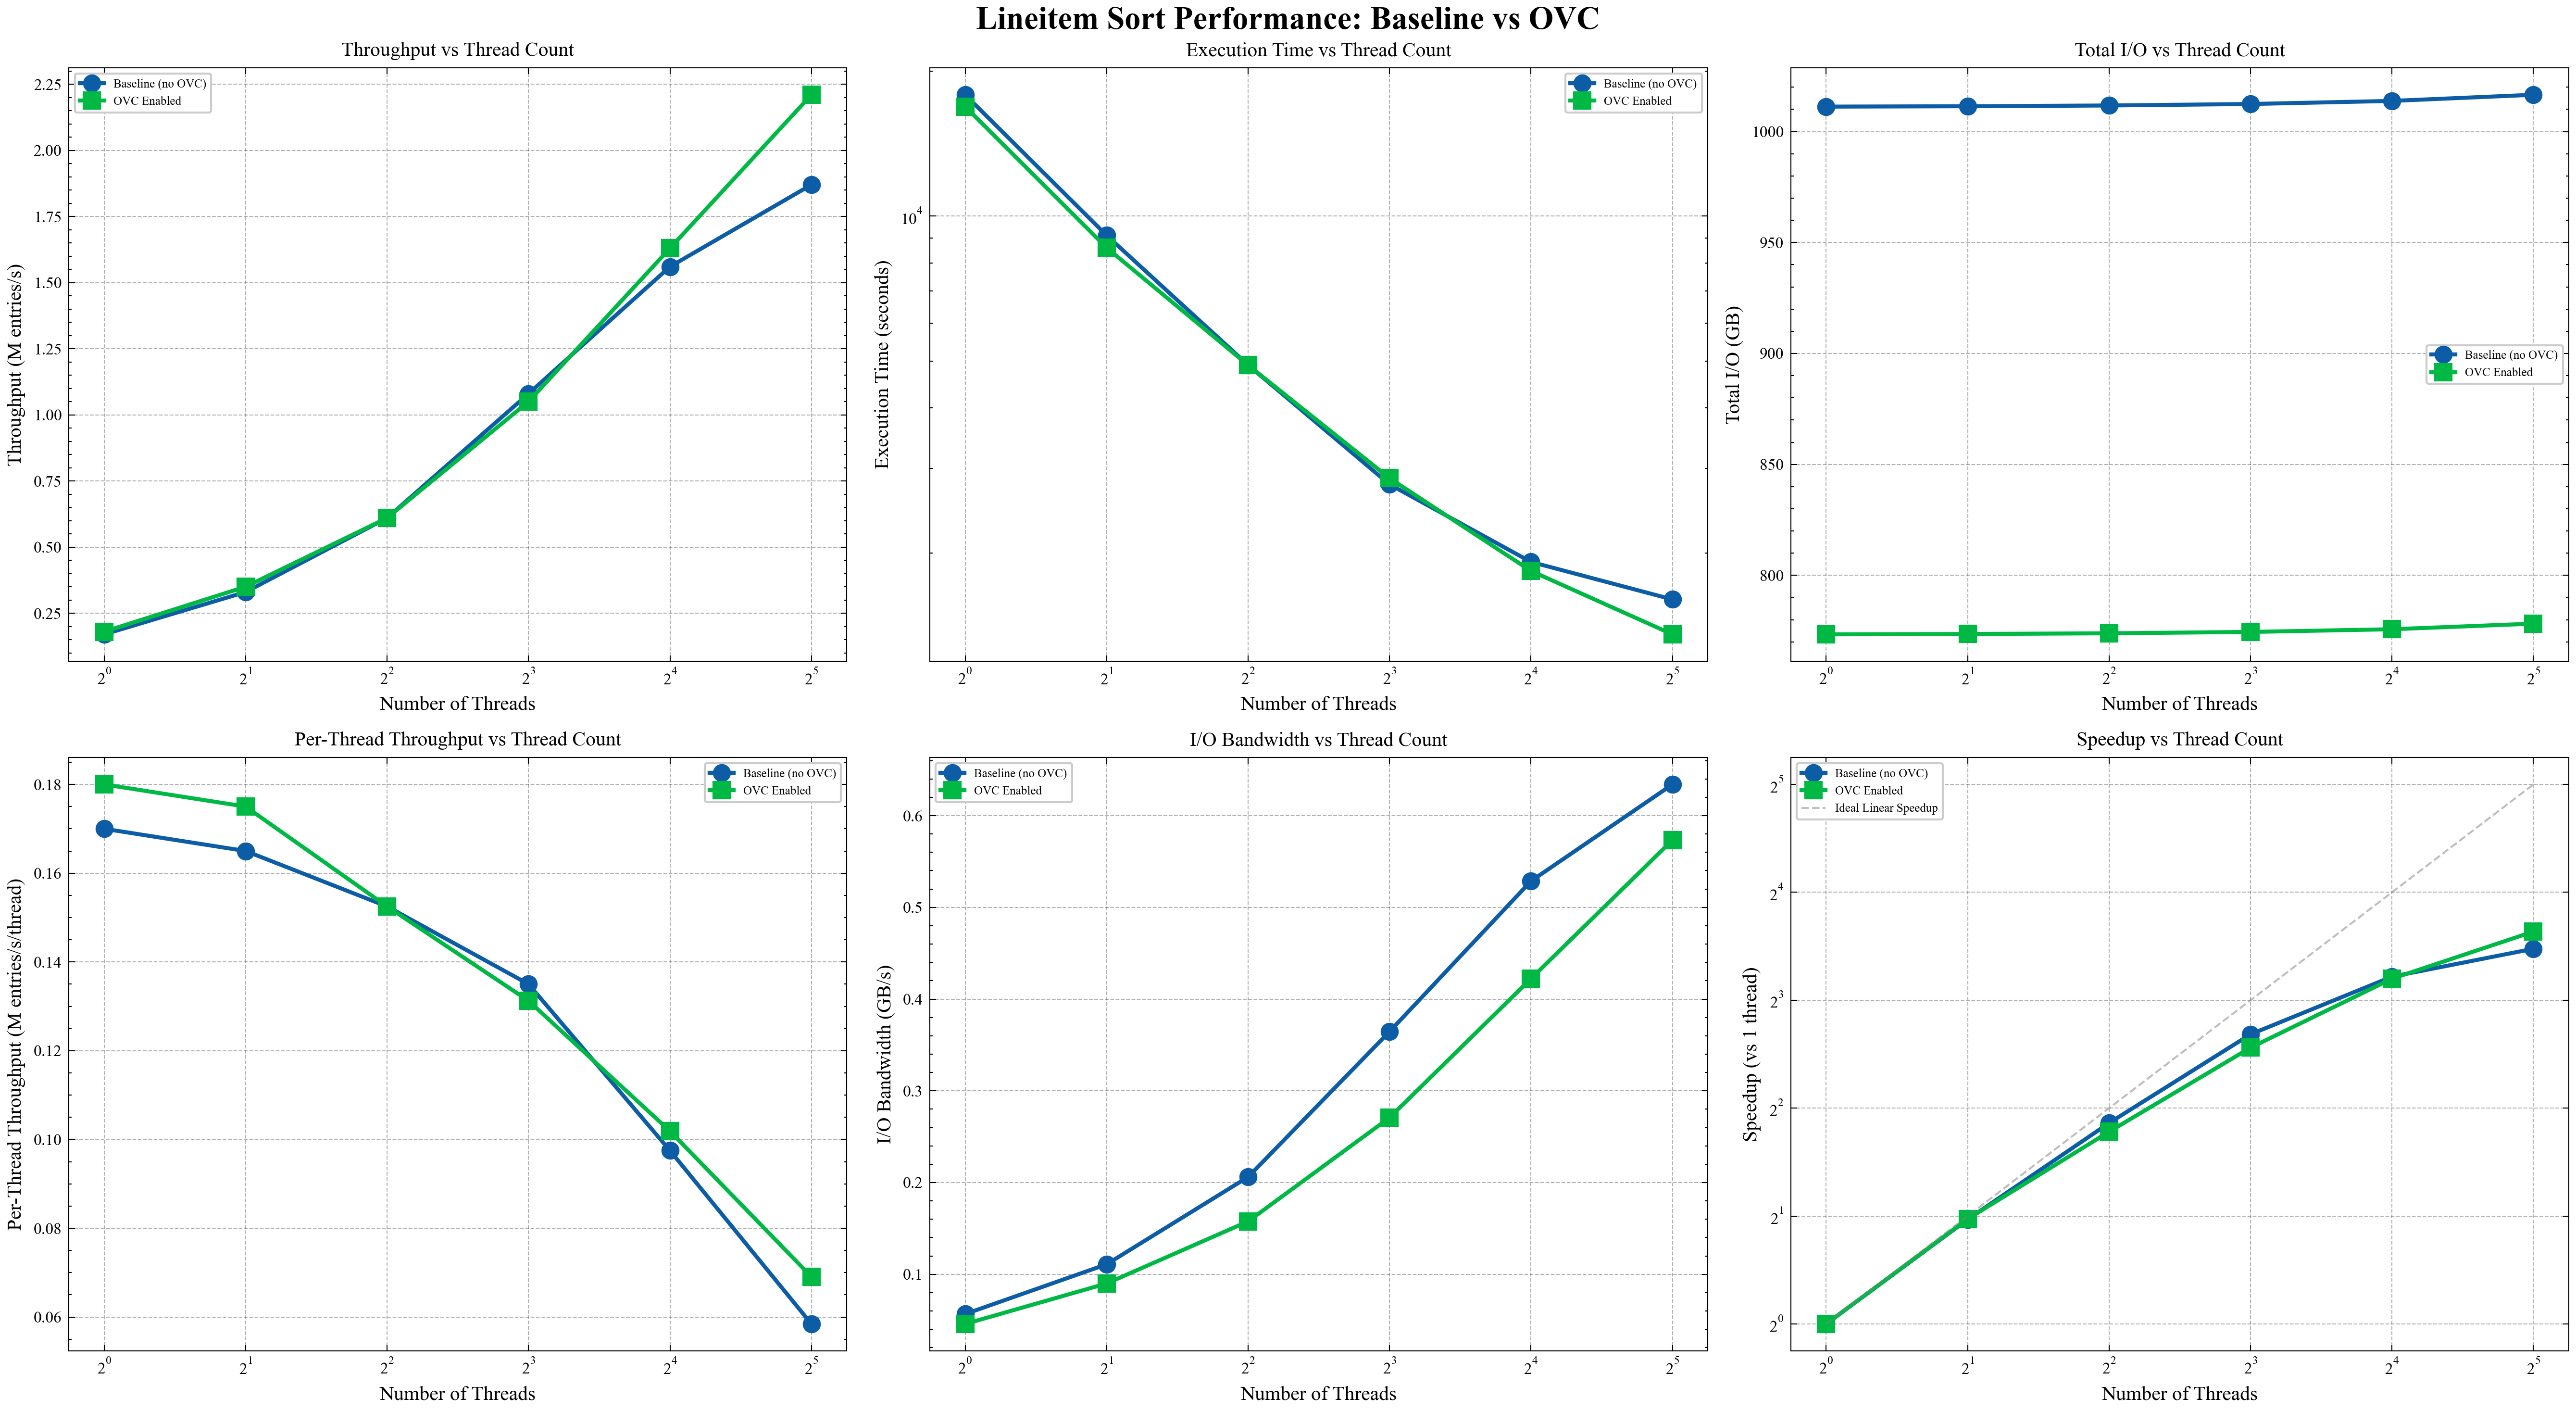

In [5]:
# Create the comparison plots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Lineitem Sort Performance: Baseline vs OVC', fontsize=16, fontweight='bold')

# Plot 1: Throughput vs Threads
ax1 = axes[0, 0]
ax1.plot(baseline_threads, baseline_throughput, 'o-', label='Baseline (no OVC)', linewidth=2, markersize=8)
ax1.plot(ovc_threads, ovc_throughput, 's-', label='OVC Enabled', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Threads')
ax1.set_ylabel('Throughput (M entries/s)')
ax1.set_title('Throughput vs Thread Count')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log', base=2)

# Plot 2: Execution Time vs Threads
ax2 = axes[0, 1]
ax2.plot(baseline_threads, baseline_time, 'o-', label='Baseline (no OVC)', linewidth=2, markersize=8)
ax2.plot(ovc_threads, ovc_time, 's-', label='OVC Enabled', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Threads')
ax2.set_ylabel('Execution Time (seconds)')
ax2.set_title('Execution Time vs Thread Count')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xscale('log', base=2)
ax2.set_yscale('log')

# Plot 3: Total I/O vs Threads
ax3 = axes[0, 2]
ax3.plot(baseline_threads, baseline_io, 'o-', label='Baseline (no OVC)', linewidth=2, markersize=8)
ax3.plot(ovc_threads, ovc_io, 's-', label='OVC Enabled', linewidth=2, markersize=8)
ax3.set_xlabel('Number of Threads')
ax3.set_ylabel('Total I/O (GB)')
ax3.set_title('Total I/O vs Thread Count')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_xscale('log', base=2)

# Plot 4: Per-Thread Throughput vs Threads
ax4 = axes[1, 0]
ax4.plot(baseline_threads, baseline_per_thread, 'o-', label='Baseline (no OVC)', linewidth=2, markersize=8)
ax4.plot(ovc_threads, ovc_per_thread, 's-', label='OVC Enabled', linewidth=2, markersize=8)
ax4.set_xlabel('Number of Threads')
ax4.set_ylabel('Per-Thread Throughput (M entries/s/thread)')
ax4.set_title('Per-Thread Throughput vs Thread Count')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.set_xscale('log', base=2)

# Plot 5: I/O Bandwidth vs Threads
ax5 = axes[1, 1]
ax5.plot(baseline_threads, baseline_bandwidth, 'o-', label='Baseline (no OVC)', linewidth=2, markersize=8)
ax5.plot(ovc_threads, ovc_bandwidth, 's-', label='OVC Enabled', linewidth=2, markersize=8)
ax5.set_xlabel('Number of Threads')
ax5.set_ylabel('I/O Bandwidth (GB/s)')
ax5.set_title('I/O Bandwidth vs Thread Count')
ax5.legend()
ax5.grid(True, alpha=0.3)
ax5.set_xscale('log', base=2)

# Plot 6: Speedup comparison (relative to 1 thread baseline)
ax6 = axes[1, 2]
baseline_speedup = [baseline_time[0] / t for t in baseline_time]
ovc_speedup = [ovc_time[0] / t for t in ovc_time]
ax6.plot(baseline_threads, baseline_speedup, 'o-', label='Baseline (no OVC)', linewidth=2, markersize=8)
ax6.plot(ovc_threads, ovc_speedup, 's-', label='OVC Enabled', linewidth=2, markersize=8)
# Add ideal linear speedup line
ax6.plot(baseline_threads, baseline_threads, '--', color='gray', alpha=0.5, label='Ideal Linear Speedup')
ax6.set_xlabel('Number of Threads')
ax6.set_ylabel('Speedup (vs 1 thread)')
ax6.set_title('Speedup vs Thread Count')
ax6.legend()
ax6.grid(True, alpha=0.3)
ax6.set_xscale('log', base=2)
ax6.set_yscale('log', base=2)

plt.tight_layout()
plt.savefig('thread_count_analysis.png', dpi=300, bbox_inches='tight')
plt.savefig('thread_count_analysis.svg', bbox_inches='tight')
plt.show()

In [6]:
# Print summary statistics
print("="*80)
print("PERFORMANCE SUMMARY")
print("="*80)
print(f"\nBaseline (no OVC):")
print(f"  Best throughput: {max(baseline_throughput):.2f} M entries/s at {baseline_threads[baseline_throughput.index(max(baseline_throughput))]} threads")
print(f"  Fastest time: {min(baseline_time):.2f} s at {baseline_threads[baseline_time.index(min(baseline_time))]} threads")
print(f"  Total I/O range: {min(baseline_io):.2f} - {max(baseline_io):.2f} GB")
print(f"  Max I/O bandwidth: {max(baseline_bandwidth):.3f} GB/s at {baseline_threads[baseline_bandwidth.index(max(baseline_bandwidth))]} threads")

print(f"\nOVC Enabled:")
print(f"  Best throughput: {max(ovc_throughput):.2f} M entries/s at {ovc_threads[ovc_throughput.index(max(ovc_throughput))]} threads")
print(f"  Fastest time: {min(ovc_time):.2f} s at {ovc_threads[ovc_time.index(min(ovc_time))]} threads")
print(f"  Total I/O range: {min(ovc_io):.2f} - {max(ovc_io):.2f} GB")
print(f"  Max I/O bandwidth: {max(ovc_bandwidth):.3f} GB/s at {ovc_threads[ovc_bandwidth.index(max(ovc_bandwidth))]} threads")

print(f"\nI/O Savings with OVC:")
for i in range(len(baseline_threads)):
    if baseline_threads[i] == ovc_threads[i]:
        io_reduction = (1 - ovc_io[i] / baseline_io[i]) * 100
        time_improvement = (1 - ovc_time[i] / baseline_time[i]) * 100
        print(f"  {baseline_threads[i]:2d} threads: I/O reduced by {io_reduction:5.2f}%, Time improved by {time_improvement:5.2f}%")
        
print("\n" + "="*80)

PERFORMANCE SUMMARY

Baseline (no OVC):
  Best throughput: 1.87 M entries/s at 32 threads
  Fastest time: 1603.30 s at 32 threads
  Total I/O range: 1011.24 - 1016.58 GB
  Max I/O bandwidth: 0.634 GB/s at 32 threads

OVC Enabled:
  Best throughput: 2.21 M entries/s at 32 threads
  Fastest time: 1357.24 s at 32 threads
  Total I/O range: 773.43 - 778.24 GB
  Max I/O bandwidth: 0.573 GB/s at 32 threads

I/O Savings with OVC:
   1 threads: I/O reduced by 23.52%, Time improved by  5.46%
   2 threads: I/O reduced by 23.51%, Time improved by  5.73%
   4 threads: I/O reduced by 23.51%, Time improved by  0.02%
   8 threads: I/O reduced by 23.50%, Time improved by -2.99%
  16 threads: I/O reduced by 23.48%, Time improved by  4.21%
  32 threads: I/O reduced by 23.45%, Time improved by 15.35%

